In [1]:
import os
import sys
import numpy as np
from numba import jit
from datetime import datetime

import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.animation as animation

### Just some `matplotlib` and `seaborn` parameter tuning

In [2]:
axistitlesize = 26
axisticksize = 23
axislabelsize = 26
axislegendsize = 23
axistextsize = 20
axiscbarfontsize = 15

# Set axtick dimensions
major_size = 6
major_width = 1.2
minor_size = 3
minor_width = 1
mpl.rcParams['xtick.major.size'] = major_size
mpl.rcParams['xtick.major.width'] = major_width
mpl.rcParams['xtick.minor.size'] = minor_size
mpl.rcParams['xtick.minor.width'] = minor_width
mpl.rcParams['ytick.major.size'] = major_size
mpl.rcParams['ytick.major.width'] = major_width
mpl.rcParams['ytick.minor.size'] = minor_size
mpl.rcParams['ytick.minor.width'] = minor_width

mpl.rcParams.update({'figure.autolayout': False})

# Seaborn style settings
sns.set_style({'axes.axisbelow': True,
               'axes.edgecolor': '.8',
               'axes.facecolor': 'white',
               'axes.grid': False,
               'axes.labelcolor': '.15',
               'axes.spines.bottom': True,
               'axes.spines.left': True,
               'axes.spines.right': True,
               'axes.spines.top': True,
               'figure.facecolor': 'white',
               'font.family': ['sans-serif'],
               'font.sans-serif': ['Arial',
                'DejaVu Sans',
                'Liberation Sans',
                'Bitstream Vera Sans',
                'sans-serif'],
               'grid.color': '.8',
               'grid.linestyle': '--',
               'image.cmap': 'rocket',
               'lines.solid_capstyle': 'round',
               'patch.edgecolor': 'w',
               'patch.force_edgecolor': True,
               'text.color': '.15',
               'xtick.bottom': True,
               'xtick.color': '.15',
               'xtick.direction': 'in',
               'xtick.top': True,
               'ytick.color': '.15',
               'ytick.direction': 'in',
               'ytick.left': True,
               'ytick.right': True})

# Colorpalettes, colormaps, etc.
sns.set_palette(palette='rocket')

## 1. Create initial conditions

In [3]:
def create_pool(IC : np.ndarray,
                height : int, width : int,
                pos_x : int, pos_y: int):
  
  # The game arena (pool) that will be updated in every iteration
  pool = np.zeros((height, width))

  # Place IC on the arena to an arbitrary place
  pool[pos_y:pos_y++IC.shape[0],pos_x:pos_x+IC.shape[1]] = IC
  
  return pool

## 2. Evolve the simulation

In [4]:
def get_nonzero(pool : np.ndarray):
  
  # Coordinates of non-zero tiles
  # We only need to iterate over non-zero tiles and their immediate surrounding
  ## 1. Create a coordinate grid
  X, Y = np.meshgrid(np.arange(0,pool.shape[0],1), np.arange(0,pool.shape[1],1))
  ## 2. Mask out non-zero tiles and identify their coordinates
  mask = pool==1
  nonzero = np.c_[X[mask], Y[mask]]
  
  return nonzero

In [5]:
def get_neighbour_grid(pool : np.ndarray,
                       x : int, y : int):
  
  # Nice solution on StackOverflow:
  # https://stackoverflow.com/questions/15113181/slicing-numpy-array-in-periodic-conditions
  sl_0 = np.array(range(x-1,x+2)).reshape(-1,1)%pool.shape[0]
  sl_1 = np.array(range(y-1,y+2)).reshape(1,-1)%pool.shape[1]
  
  # Get a periodic gridmesh
  X, Y = np.meshgrid(sl_0, sl_1)
  
  return X, Y

In [6]:
def get_neighbour_coordinates(pool : np.ndarray,
                              x : int, y : int,
                              periodic : bool):
  
  X, Y = get_neighbour_grid(pool, x, y)
  
  if not periodic:
    # If the central tile is situated on one of the edges, delete the values of
    # the `X` and 'Y' arrays on that side
    if x == 0: # Left-side wall
      X = np.delete(X, 0, axis=1)
      Y = np.delete(Y, 0, axis=1)
    elif x == width-1: # Right-side wall
      X = np.delete(X, -1, axis=1)
      Y = np.delete(Y, -1, axis=1)
    if y == 0: # Upper wall
      X = np.delete(X, 0, axis=0)
      Y = np.delete(Y, 0, axis=0)
    elif y == height-1: # Bottom wall
      X = np.delete(X, -1, axis=0)
      Y = np.delete(Y, -1, axis=0)
  else:
    pass
  
  return X, Y

In [7]:
def get_neighbour_values(pool : np.ndarray,
                         X : np.ndarray, Y : np.ndarray):

  nbrs = pool[X.T, Y.T]

  return nbrs

In [8]:
@jit(nopython=True)
def decide_flip(pool : np.ndarray,
                x : int, y : int,
                nbrs : np.ndarray,
                n_max : int,
                periodic : bool):

  # Count the number of neighbours around the current tile at (x,y)
  n_nbrs = int(nbrs.sum())
  
  if pool[x,y] == 1:
    if (n_nbrs - 1 == n_max) or (n_nbrs - 1 == n_max - 1):
      return False
  if pool[x,y] == 0:
    if n_nbrs != n_max:
      return False

  return True

In [9]:
def flip(pool : np.ndarray,
         n_max : int,
         periodic : bool):
  
  nonzero = get_nonzero(pool)
  checked_tiles = set()
  flipped_tiles = set()
  
  # We only need to check that any of the intersting tiles flipped states or not
  for x, y in nonzero:
    X, Y = get_neighbour_coordinates(pool, x, y, periodic)
    iter_through = set(tuple(i) for i in np.c_[Y.reshape(-1), X.reshape(-1)])
    iter_through -= checked_tiles
    for i in iter_through: checked_tiles.add(i)
    
    for xi, yi in iter_through:
      Xi, Yi = get_neighbour_coordinates(pool, xi, yi, periodic)
      nbrs = get_neighbour_values(pool, Xi, Yi)
      flip = decide_flip(pool, xi, yi, nbrs, n_max, periodic)
    
      if flip:
        flipped_tiles.add((xi,yi))
        
  return flipped_tiles

In [10]:
def step(pool : np.ndarray,
         flipped_tiles : set):
  
  new_pool = pool.copy()
  for x,y in flipped_tiles:
    new_pool[x,y] = 1 - pool[x,y]
    
  return new_pool

In [11]:
def run(pool : np.ndarray,
        n_max : int=3,
        periodic : bool=True,
        n_steps : int=180):

  old_pool = pool.copy()
  for i in range(n_steps):
    flipped_tiles = flip(old_pool, n_max, periodic)
    old_pool = step(old_pool, flipped_tiles)
    
  return old_pool

## Simulation parameters

In [12]:
# Parameters for game arena (pool)
## 1. Size of the arena
height = 80
width = 80
## 2. Whether to have periodic boundary conditions or not
periodic = True
## 3. Rule for evolution
n_max = 3

# Parameters for the initial condition
## 1. Coordinates of the upper left corner of the initial condition
pos_x = 5
pos_y = 5

In [13]:
# Initial conditions
IC = np.array([
  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0],
  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0],
  [0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
  [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
  [1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
  [1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0],
  [0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0],
  [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
  [0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
])

In [14]:
pool = create_pool(IC, height, width, pos_x, pos_y)

In [15]:
%%time
sec = 25
final = run(pool, n_max, periodic=True, n_steps=sec*12)

CPU times: user 5.8 s, sys: 13.7 ms, total: 5.81 s
Wall time: 5.84 s


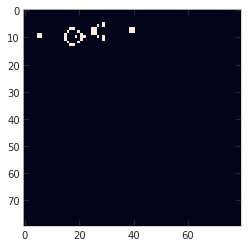

In [16]:
plt.imshow(pool, interpolation='none')

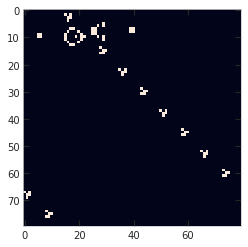

In [17]:
plt.imshow(final, interpolation='none')